# Projet numérique de science des données - WOTAWA Cécile-Aurore et PIERFITTE Auguste

## Introduction au projet

Il s'agit dans ce projet d'utiliser des données cartographiques décrivant des carrées de 30m x 30m pour construire un modèle prédictif de l'espèce d'arbre présente sur un tel carré.

Le but final est d'appliquer ce modèle pour faire des prédictions pour des données pour lesquelles vous ne disposez pas d'une étiquette.

__Consignes :__ 
* Vous devez rendre, par binôme :
    * un notebook jupyter
    * un fichier de prédictions (voir plus bas pour le format)
* __Renseignez vos noms/prénoms__ dans le titre du notebook
* Vous avez jusqu'au __1er juillet midi heure de Paris__
* Déposez vos fichiers [sur Campus](https://campus.mines-paristech.fr/course/view.php?id=404) dans la section dédiée (un seul rendu par binôme est nécessaire)


__Déroulé :__
* Les séances du lundi 14/06 (15h30-17h) et jeudi 24/06 (15h30-17h) sont dédiées au projet numérique. Faites-en bon usage.
* Certaines sections font appel à des notions qui n'auront pas encore été vues le 14/06 ; c'est indiqué le cas échéant.

## Données

### Données publiques et privées

Le dossier `data/` contient deux jeux de données :
* `data/foret_public.tsv` contient les données étiquetées, à partir desquelles construire votre modèle
* `data/foret_prive.tsv` contient les données non-étiquetées, pour lesquelles faire vos prédictions.

Chaque ligne dans les données correspond à un carré de 30 m x 30m, décrit par les variables suivantes :
* `altitude` : altitude en mètres
* `exposition` : azimut en degrés 
* `pente` : pente en degrés
* `distance_horizontale_hydro` : distance horizontale au point d'eau le plus proche (en mètres)
* `distance_verticale_hydro` : distance verticale au point d'eau le plus proche (en mètres)
* `distance_horizontale_route` : distance horizontale à la route la plus proche (en mètres)
* `ombrage_0900` : index d'ombrages à 9h du matin, au solstice, sur une échelle de 0 à 255
* `ombrage_1200` : index d'ombrages à midi, au solstice, sur une échelle de 0 à 255
* `ombrage_1500` : index d'ombrages à 15h, au solstice, sur une échelle de 0 à 255
* `distance_horizontale_depart_feu` : distance horizontale au départ de feu de forêt le plus proche (en mètres)
* `espece` : étiquette : espèce d'arbre présente (0 = pin tordu ; 1 = peuplier)|

### Chargement des données étiquetées

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
df_public = pd.read_csv('data/foret_public.tsv', delimiter='\t')

In [4]:
df_public.head()

altitude  exposition  pente  distance_horizontale_hydro  \
0      2804         139      9                         268   
1      2785         155     18                         242   
2      2579         132      6                         300   
3      2886         151     11                         371   
4      2742         134     22                         150   

   distance_verticale_hydro  distance_horizontale_route  ombrage_0900  \
0                        65                        3180           234   
1                       118                        3090           238   
2                       -15                          67           230   
3                        26                        5253           234   
4                        69                        3215           248   

   ombrage_1200  ombrage_1500  distance_horizontale_depart_feu  espece  
0           238           135                             6121       0  
1           238           122                             6211       0  
2           237           140                             6031       0  
3           240           136                             4051       0  
4           224            92                             6091       0

### Extraction de la matrice de design et des étiquettes 

In [5]:
X_public = np.array(df_public.drop(columns=["espece"]))
y_public = np.array(df_public["espece"])

### Visualisation des variables

#### Question 1
Visualisez chacune des variables de `X_public` sous la forme de deux histogrammes superposés, l'un correspondant aux observations de la classe positive, l'autre correspondant aux observations de la classe négative.

__Conseils :__
* utilisez `pos_indices = np.where(y_public==1)[0]` pour déterminer les indices des lignes de `y_public` (et donc dans `X_public`) dont l'étiquette vaut 0.
* utilisez l'argument `alpha` de `plt.hist` pour rendre vos histogrammes transparents.

In [6]:
# setting up

features = list(df_public.drop(columns=["espece"]).columns)

peuplier_indices = np.where(y_public == 1)[0]
pin_indices = np.where(y_public == 0)[0]

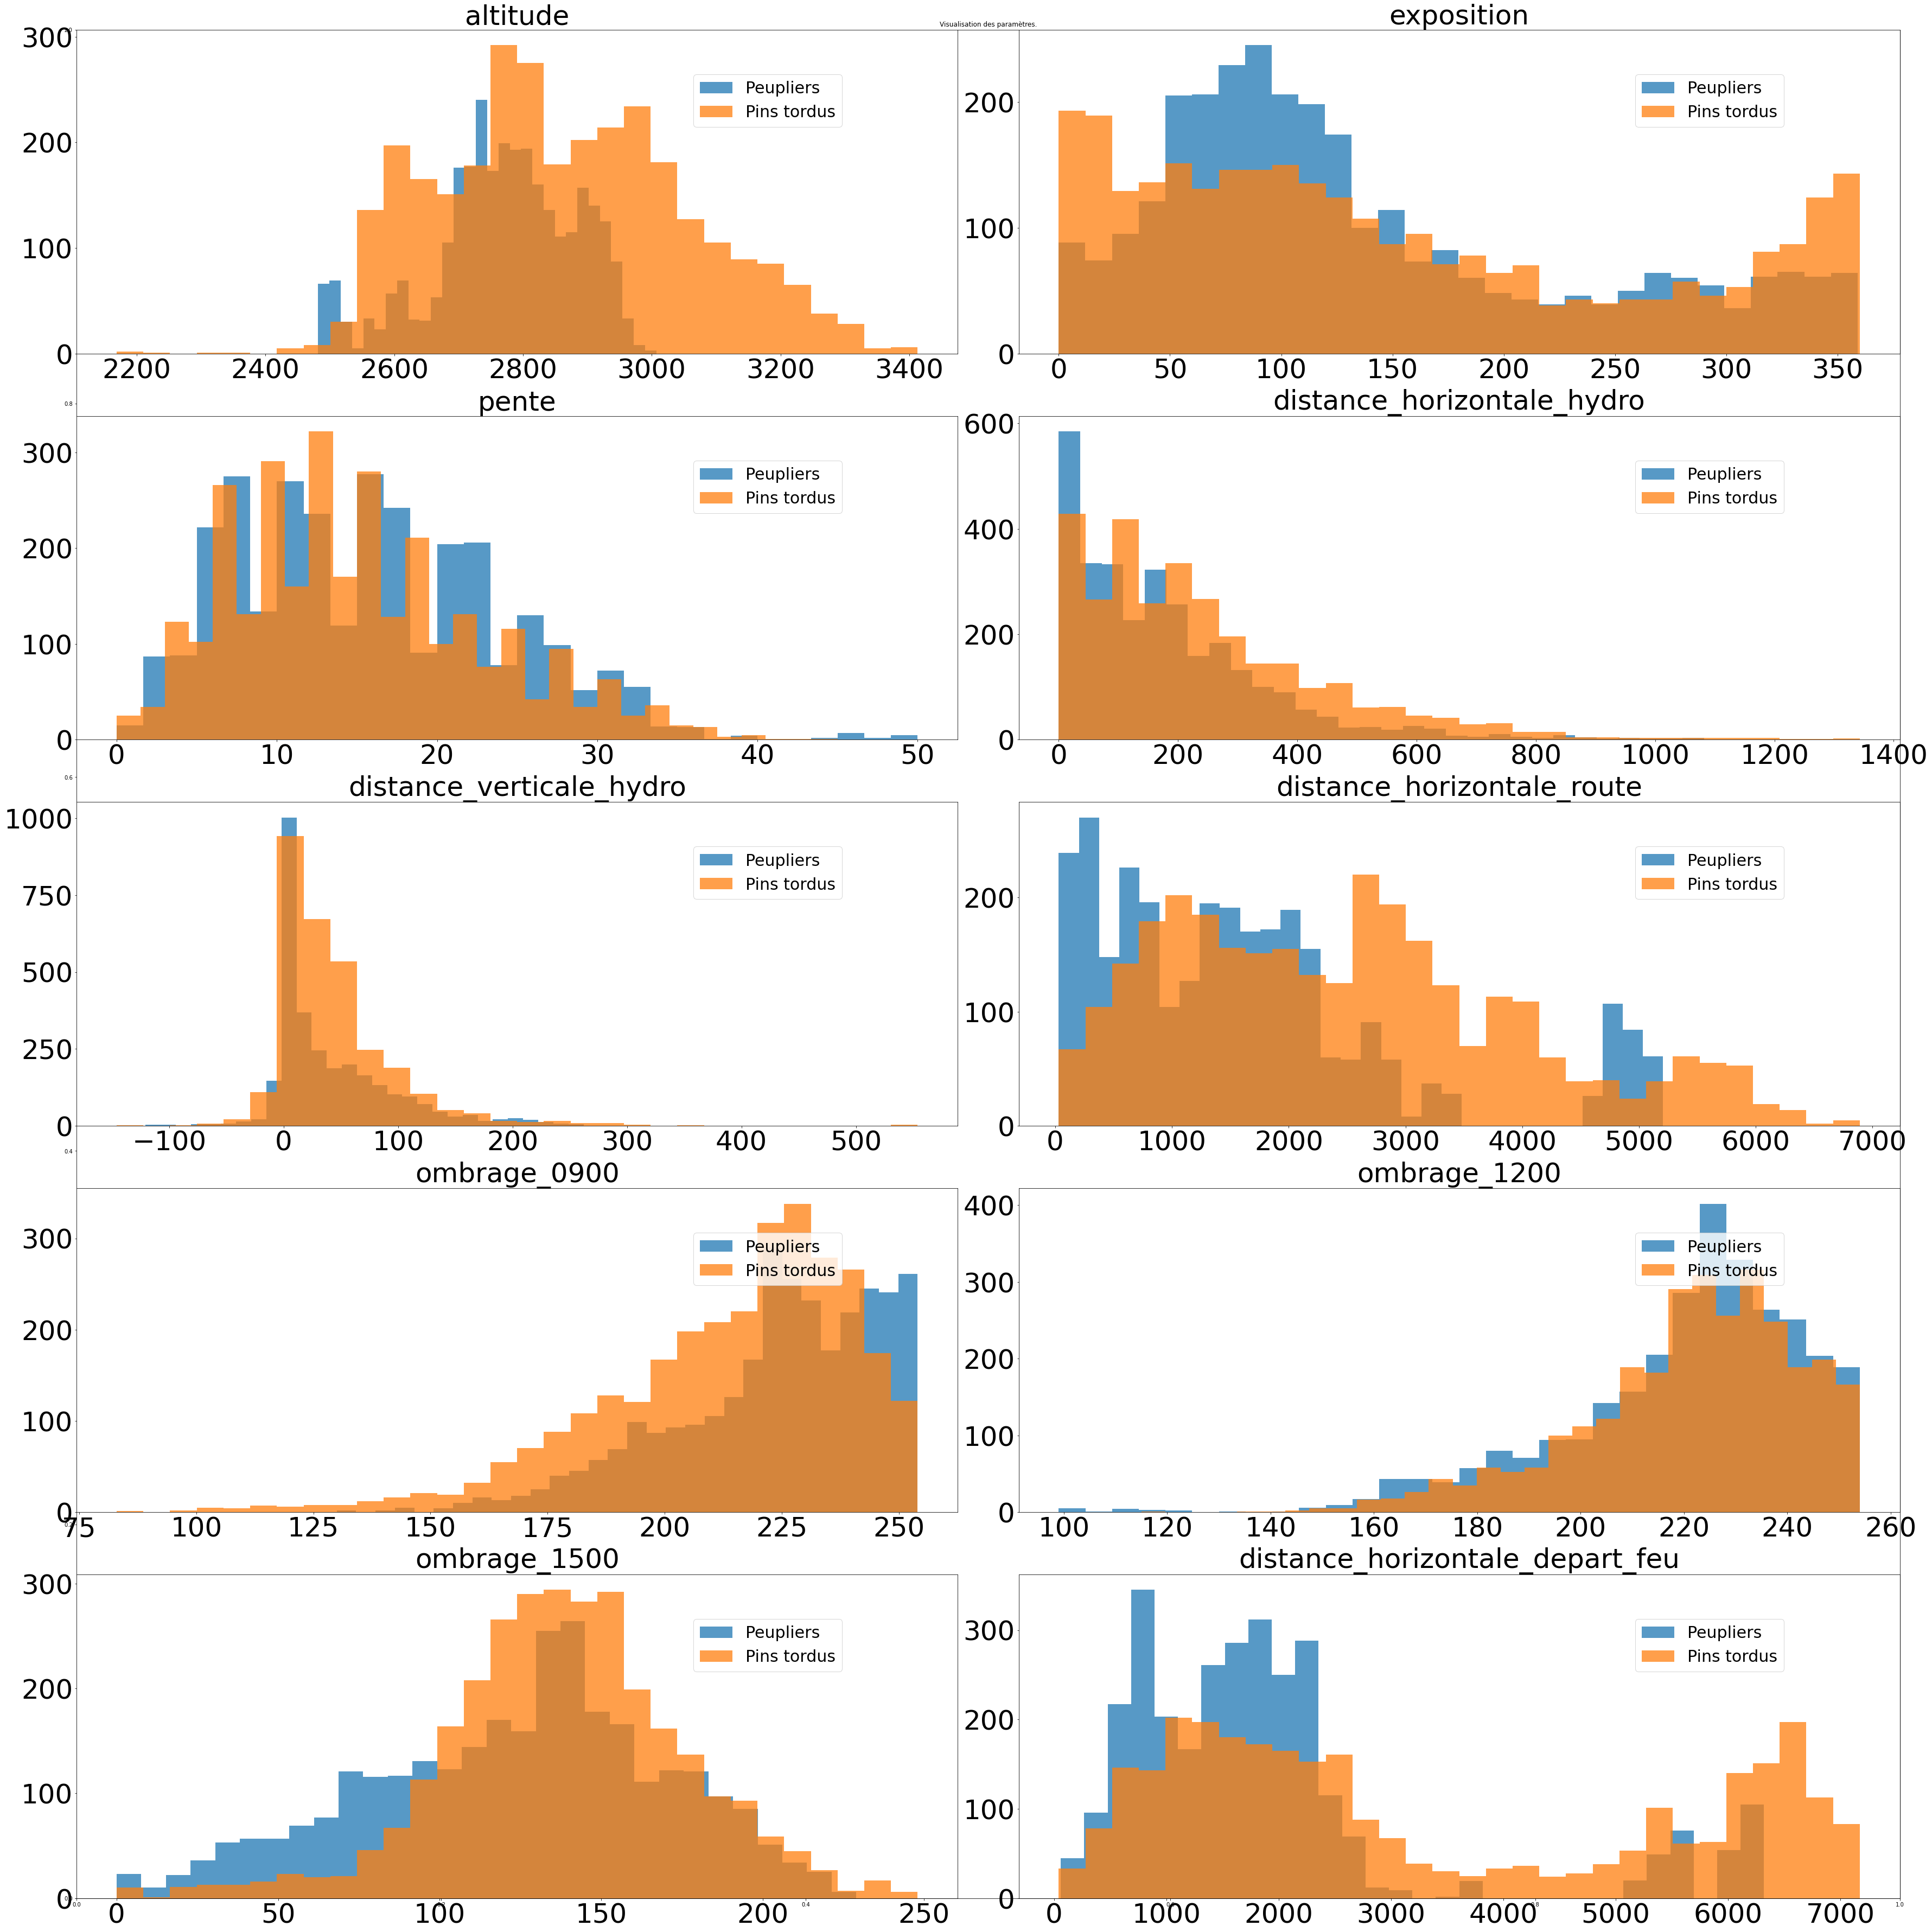

In [7]:
fig = plt.figure(figsize(50, 50))

plt.title("Visualisation des paramètres.")
plt.rc('ytick', labelsize=50) 
plt.rc('xtick', labelsize=50) 

for idx in range(len(features)):
    # create subplot
    ax = fig.add_subplot(5,2, idx + 1)
    
    # plot the new histogram
    h = ax.hist(X_public[peuplier_indices][:, idx], bins = 30, edgecolor = 'none',
               label = "Peupliers", alpha = 0.75)
    
    # plot the new histogram
    h = ax.hist(X_public[pin_indices][:, idx], bins = 30, edgecolor = 'none',
               label = "Pins tordus", alpha = 0.75)
    
    # use the name of the feature as a title for each histogram
    ax.set_title("%s" % features[idx], fontsize = 50)
    
    ax.legend(loc=(0.7, 0.7), fontsize = 30)
    
# espacement entre les subplots
fig.tight_layout(pad=1.0)

#### Question 2
Pensez-vous qu'il va être aisé de distinguer les deux classes ?

__Réponse :__ À première vue, les deux classes sont similaires sur la plupart des variables, il semble compliqué de les distinguer immédiatement.

### Pré-traitement des variables

#### Question 3
Transformez vos variables d'une manière qui vous parait judicieuse, en vous appuyant notamment sur la PC 3. Vous pouvez essayer différents pré-traitements, mais ce n'est pas nécessaire. Justifiez vos choix. Utilisez un array numpy `X_public_preprocessed` pour enregistrer le résultat.

__Réponse :__ Aucune des variables n'est une variable binaire (on a retiré la colonne espèce), l'utilisation d'une transformation min-max paraît donc peu judicieuse.
En supposant que les résidus sont normalement distribués (peut-être abusif à cette étape du raisonnement), il araît légitime de centrer réduire nos variables.

In [8]:
from sklearn import preprocessing

In [9]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_public)

StandardScaler()

In [10]:
X_public_preprocessed = standard_scaler.transform(X_public)

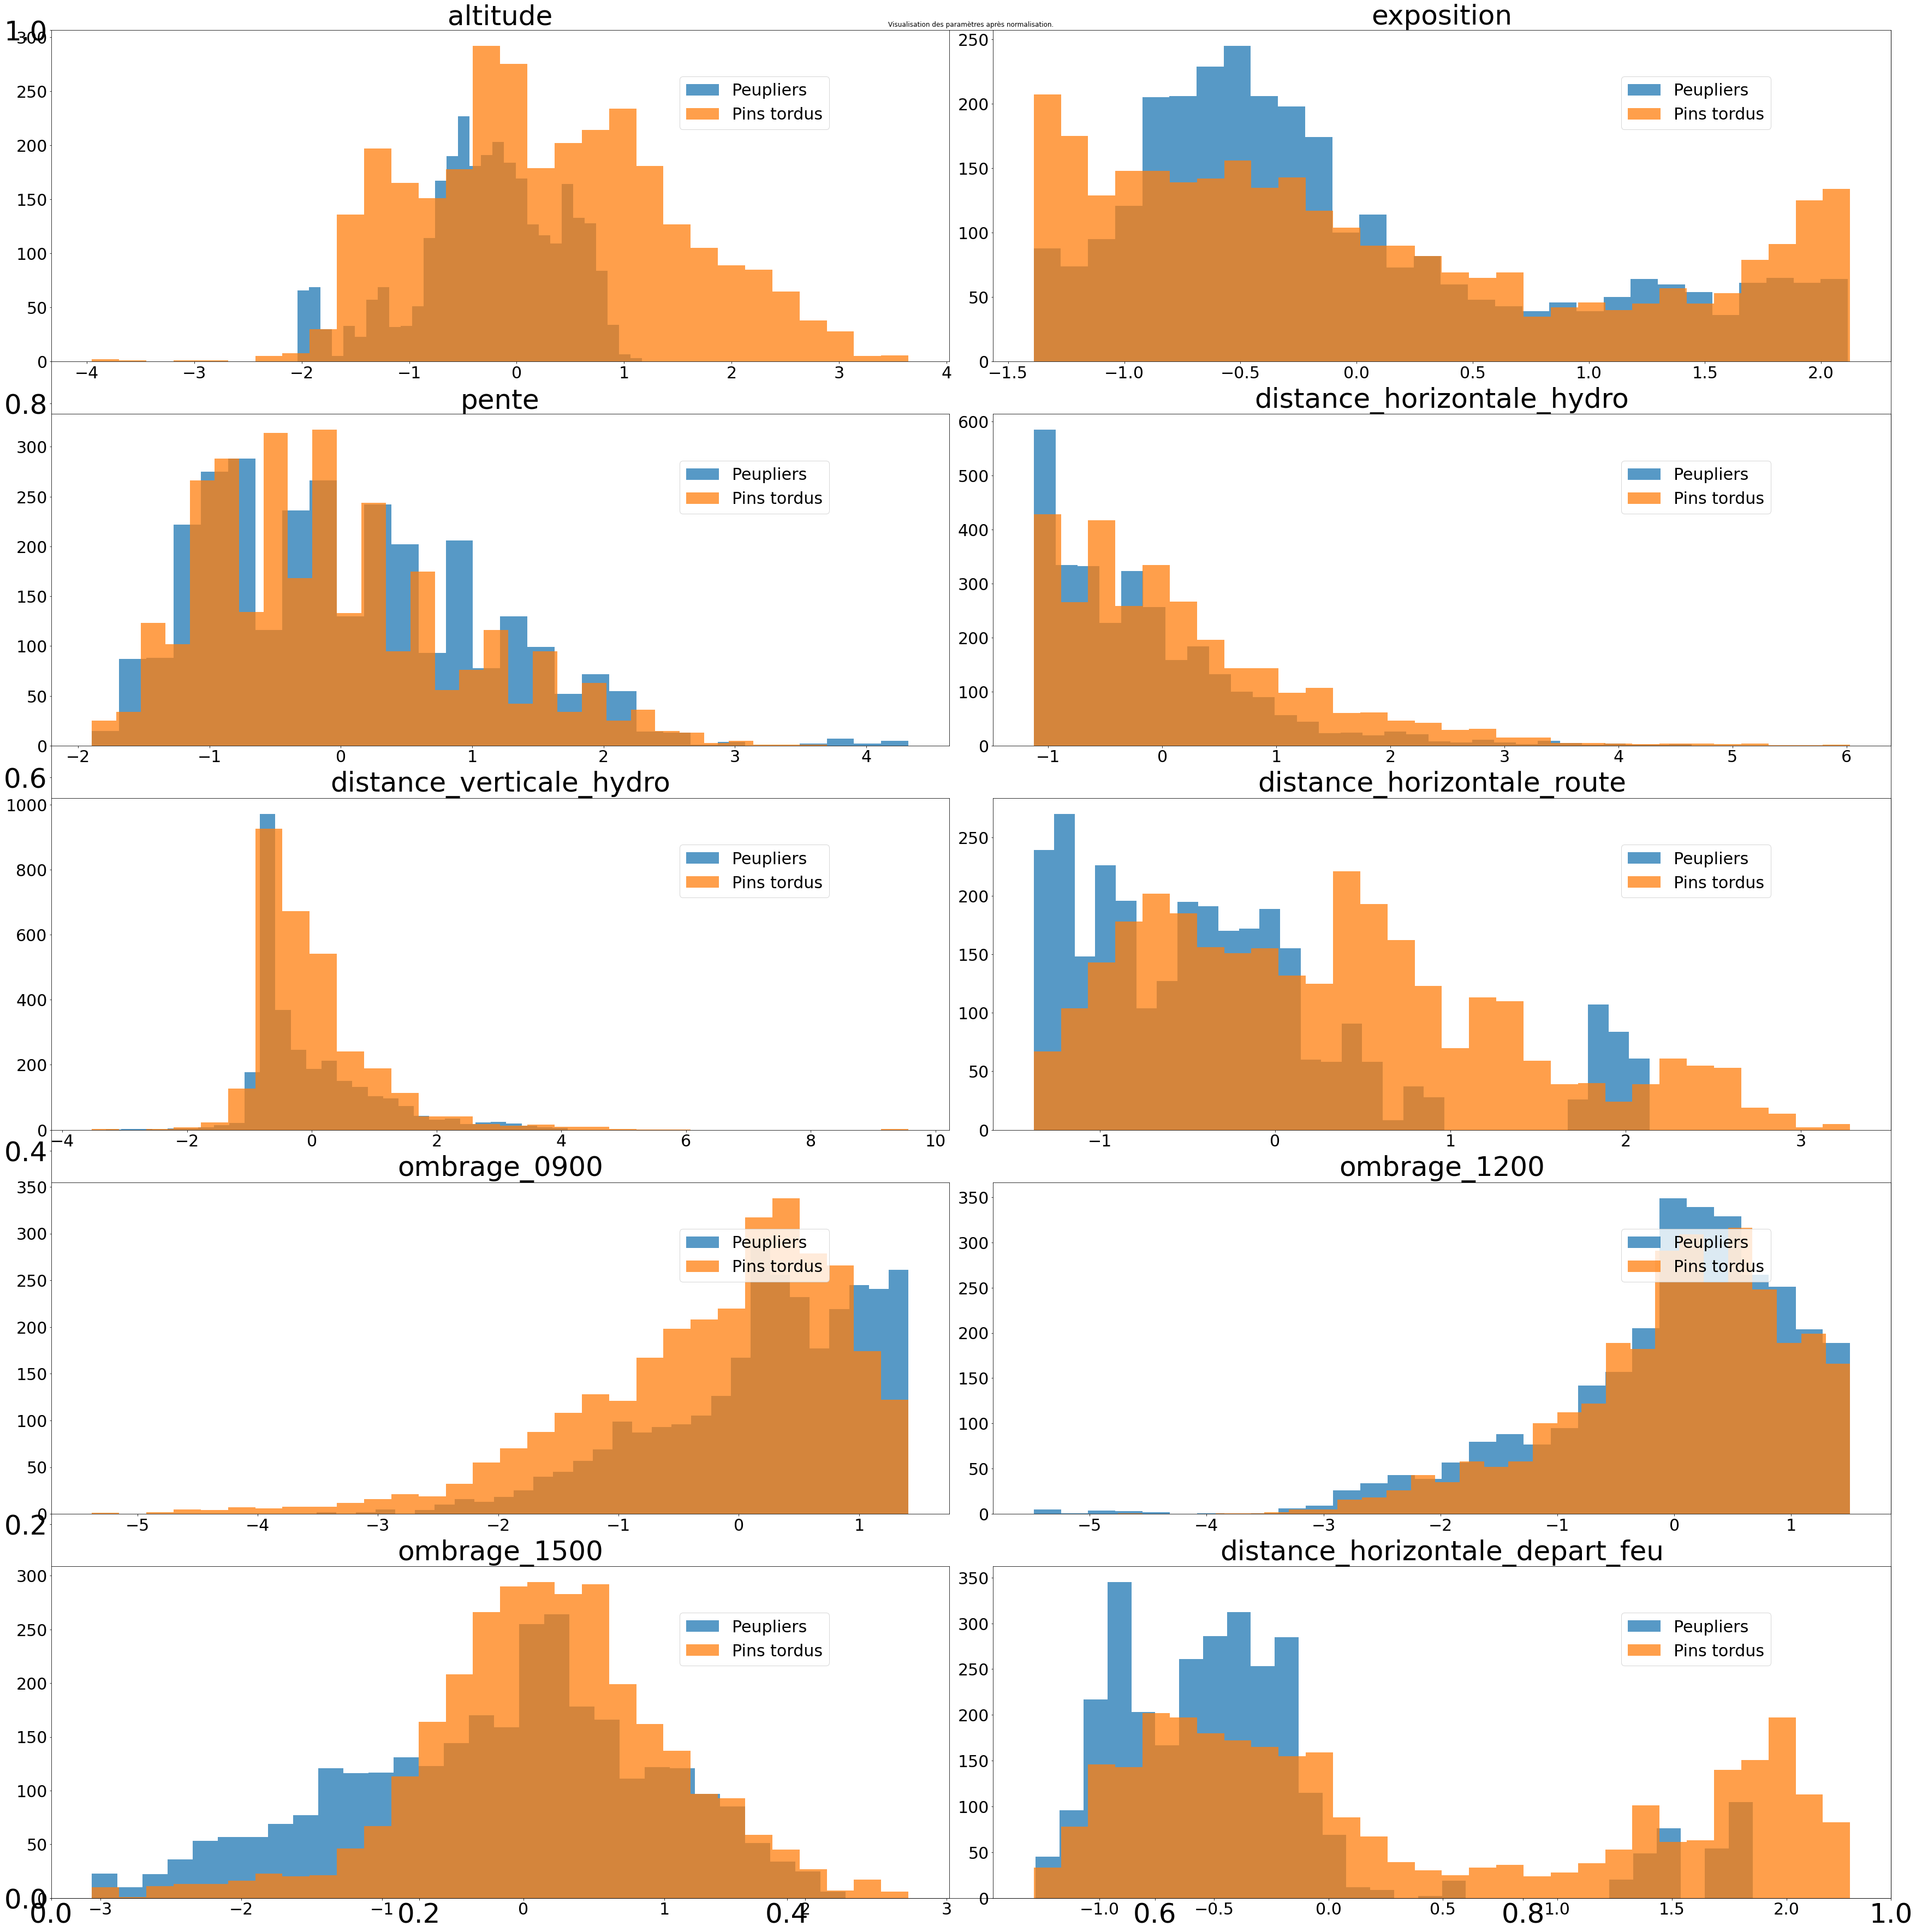

In [11]:
fig = plt.figure(figsize(50, 50))

plt.title("Visualisation des paramètres après normalisation.")
plt.rc('ytick', labelsize=30) 
plt.rc('xtick', labelsize=30) 


for idx in range(len(features)):
    # create subplot
    ax = fig.add_subplot(5,2, idx + 1)
    
    # plot the new histogram
    h = ax.hist(X_public_preprocessed[peuplier_indices][:, idx], bins = 30, edgecolor = 'none',
               label = "Peupliers", alpha = 0.75)
    
    # plot the new histogram
    h = ax.hist(X_public_preprocessed[pin_indices][:, idx], bins = 30, edgecolor = 'none',
               label = "Pins tordus", alpha = 0.75)
    
    # use the name of the feature as a title for each histogram
    ax.set_title("%s" % features[idx], fontsize = 50)
    
    ax.legend(loc=(0.7, 0.7), fontsize = 30)
    
# espacement entre les subplots
fig.tight_layout(pad=1.0)

## Premier modèle : 5-NN

### Algorithme des k plus proches voisins

Nous n'avons pas encore vu d'algorithme permettant d'entraîner un modèle de classification. Nous allons donc commencer avec un modèle simple : celui des __k plus proches voisins__ (ou __kNN__, pour _k nearest neighbors_).

Dans ce modèle, la valeur de la fonction de décision en x est la proportion d'individus d'étiquette positive parmi les k plus proches voisins de x au sein des points du jeu d'entraînement ; k est fixé.

Nous allons commencer par utiliser un algorithme des k plus proches voisins avec k fixé à k=5.

#### Question 4

Entraînez un modèle des sur les données `(X_public_preprocessed, y_public)` grâce à la classe `KNeighborsClassifier` du module `neighbors` de `sklearn`, utilisez l'algorithme des 5 plus proches voisins pour entrainer un modèle sur votre jeu d'entraînement.

Documentation https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [12]:
from sklearn import neighbors

In [13]:
# initialisation d'un objet KNeighborsClassifier
predictor = neighbors.KNeighborsClassifier(n_neighbors=5)

In [14]:
# entraînement de cet objet sur les données
predictor.fit(X_public_preprocessed, y_public)

KNeighborsClassifier()

### Performance

Il existe de nombreuses métriques pour évaluer les performances d'un algorithme de classification. Nous allons ici utiliser le F-score, dont vous trouverez une description dans la documentation du module `metrics` de `sklearn` : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score et https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics.

#### Question 5
Quel serait sur nos données le F-score d'un modèle naïf prédisant systématiquement la classe positive ?

__Réponse :__ Un modèle naïf prédisant systématiquement la classe positive étiquetterait correctement toutesles classes positives correctement.
Ainsi, le F-score d'un tel algorithme serait égal à 1, bien que peu intéressant.

#### Question 6

Quelle est le F-score du modèle de 5 plus proches voisins que vous venez d'entraîner, sur les données `(X_public_preprocessed, y_public)` ?

In [15]:
from sklearn import metrics

In [16]:
y_pred = predictor.predict(X_public_preprocessed)
fscore1 = metrics.f1_score(y_public, y_pred)

In [17]:
print("F-score: %.2f" % fscore1)

F-score: 0.93


#### Question 7
* Que pensez-vous de cette performance ? 
* Est-ce une bonne idée d'évaluer le modèle sur le jeu d'entraînement ? (Réfléchissez en particulier au cas où k=1.)

__Réponse :__
* Le F-score du modèle de 5 plus proches voisins que nous venons d'entraîner, sur les données `(X_public_preprocessed, y_public)` est très proche de 1 : on peut qualifier cette performance d'excellente.
* Néanmoins, on sait qu'évaluer le modèle sur le jeu d'entraînement est une mauvaise idée de manière générale. D'autant plus que l'algorithme des k plus proches voisins va estimer un point par rapport à lui-même : peu pertinent.

## Création d'un jeu de test

À partir de maintenant, nous allons séparer les données en un jeu d'entraînement, que nous utiliserons pour entraîner différents modèles, et un jeu de test, que nous utiliserons pour les comparer. (Cf CM 8).

In [18]:
from sklearn import model_selection

In [19]:
# Use 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_public_preprocessed, y_public, test_size=0.20,
                                                                    stratify=y_public,
                                                                    random_state=53) 
X_train.shape, X_test.shape

((4800, 10), (1200, 10))

### Performance sur le jeu de test d'un 5-NN entraîné sur le jeu d'entrainement

#### Question 8.a 

Entrainez de nouveau un modèle avec l'algorithme des 5 plus proches voisins, mais cette fois, utilisez uniquement le jeu d'entraînement. __Attention__ à bien « entraîner » votre pre-processing sur le jeu d'entraînement seulement ; considérez le jeu de test comme des données que vous ne voyez pas au moment de l'entraînement.

In [20]:
# initialisation d'un objet KNeighborsClassifier
predictor = neighbors.KNeighborsClassifier(n_neighbors=5)

In [21]:
# entraînement de cet objet sur les données d'entraînement
predictor.fit(X_train, y_train)

KNeighborsClassifier()

#### Question 8.b
Évaluez le F-score sur le jeu de test du modèle entraîné à la question précédente.

In [22]:
y_pred = predictor.predict(X_test)
fscore2 = metrics.f1_score(y_test, y_pred)

In [23]:
print("F-score: %.2f" % fscore2)

F-score: 0.89


#### Question 9
Commentez le F-score obtenu ci-dessus.

__Réponse :__

Le F-score obtenu ci-dessus est _très légèrement_ inférieur à celui obtenu à la question précédente (0.93).
Il est néanmoins très proche de 1, et donc témoin d'une bonne performance de prévision.

## [À partir du CM 8 / de la PC 4] Sélection du nombre de plus proches voisins

#### Question 10.a 
Utilisez maintenant une validation croisée pour sélectionner la valeur optimale du nombre de voisins avec `GridSearchCV` (voir notamment PC4). 

Vous pouvez utiliser la grille de valeurs de k suivante, ou la modifier :

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
# définition du modèle et des valeurs de k à évaluer
knn = neighbors.KNeighborsClassifier()
k_values = np.arange(3, 32, step=2)

In [26]:
# définition de la recherche par grille
tuned_parameters = [{'n_neighbors' : k_values}]
nb_folds = 5
grid = GridSearchCV(knn, tuned_parameters, cv = nb_folds, refit = False, scoring = 'f1')

# lançons la recherche par grille 
grid.fit(X_train, y_train)

# obtenons le score F
scores = grid.cv_results_['mean_test_score']

In [27]:
# obtenons la valeur optimale du nombre de voisins
idx_max = np.argmax(scores)
best_k = k_values[idx_max]
fscore3 = scores[idx_max]

print(f"Le nombre de voisins optimal est {best_k}.")

Le nombre de voisins optimal est 3.


#### Question 10.b
Quel est le F-score correspondant au nombre de voisin optimal ?

In [28]:
print("Le F-score correspondant au nombre de voisins optimal est {0:0.2f}".format(fscore3))

Le F-score correspondant au nombre de voisins optimal est 0.89


#### Question 10.c

Quel est le F-score, sur le jeu de test, d'un modèle obtenu en entraînant un algorithme des k plus proches voisins, avec le k que vous venez de déterminer, sur le jeu d'entraînement ? Commentez.

In [29]:
# initialisation d'un objet KNeighborsClassifier
predictor = neighbors.KNeighborsClassifier(n_neighbors=best_k)

In [30]:
# entraînement de cet objet sur les données d'entraînement
predictor.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [31]:
y_pred = predictor.predict(X_test)
fscore4 = metrics.f1_score(y_test, y_pred)

In [32]:
print("F-score: %.2f" % fscore4)

F-score: 0.90


__Réponse :__ En utilisant le nombre de plus proches voisins optimal que nous venons de déterminer, le F-score est *légèrement* amélioré.

## [À partir de la PC 5] Régression logistique

### Régression logistique non-régularisée

#### Question 11.a

Entraînez une régression logistique non-régularisée sur le jeu d'entraînement.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `LogisticRegression` du module `linear_model` de `scikit-learn` ; il s'agit ainsi d'une variante de la PC5. Comme toujours, référez-vous à la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
* Pour ne pas avoir de régularisation, utilisez `penalty='none'`

In [33]:
from sklearn import linear_model

In [34]:
# initialisation d'un objet LogisticRegression
predictor = linear_model.LogisticRegression(penalty='none')

In [35]:
# entraînement de cet objet sur les données
predictor.fit(X_train, y_train)

LogisticRegression(penalty='none')

#### Question 11.b
Évaluez le F-score de cette régression logistique non-régularisée sur le jeu de test.

In [36]:
fscore5 = metrics.f1_score(y_test, predictor.predict(X_test))

In [37]:
print("F-score: %.2f" % fscore5)

F-score: 0.79


#### Question 12
Vous attendez-vous à ce qu'utiliser une régularisation l2 améliore les performances du modèle ? Pourquoi ?

__Réponse :__ Notre problème possède de nombreux paramètres, ce qui peut entraîner un surapprentissage de la part de notre modèle.
Limiter l'importance relative de ces paramètres à l'aide d'une régularisation $l_2$ permettrait donc de limiter ce phénomène, et d'améliorer la généralisation du modèle.

#### Question 13.a
Déterminez par validation croisée une valeur optimale du coefficient de régularisation d'une régression logistique avec régularisation ridge.

In [38]:
# définition du modèle et des valeurs de k à évaluer
logistic = linear_model.LogisticRegression()
lambdas = np.logspace(-4, -1, 30)

In [39]:
# définition de la recherche par grille
tuned_parameters = [{'C' : 1/lambdas}] # d'après la doc, C est l'inverse du coefficient lambda
nb_folds = 5
grid = GridSearchCV(logistic, tuned_parameters, cv = nb_folds, refit = False, scoring = 'f1')

# lançons la recherche par grille 
grid.fit(X_train, y_train)

# obtenons le score F
scores = grid.cv_results_['mean_test_score']

In [40]:
# obtenons la valeur optimale du coefficient de régularisation d'une régression logistique avec régularisation ridge.
idx_max = np.argmax(scores)
best_lambda = lambdas[idx_max]
fscore6 = scores[idx_max]

print(f"La valeur optimale du coefficient de régularisation d'une régression logistique avec régularisation ridge est {best_lambda}.")

La valeur optimale du coefficient de régularisation d'une régression logistique avec régularisation ridge est 0.0001.


#### Question 13.b
Quel est le F-score, sur le jeu de test, d'une régression logistique avec régularisation ridge et ce coefficient de régularisation optimal, entraînée sur le jeu d'entraînement ?

In [41]:
# initialisation d'un objet KNeighborsClassifier
predictor = linear_model.LogisticRegression(C = 1/best_lambda)

In [42]:
# entraînement de cet objet sur les données d'entraînement
predictor.fit(X_train, y_train)

LogisticRegression(C=10000.0)

In [43]:
y_pred = predictor.predict(X_test)
fscore7 = metrics.f1_score(y_test, y_pred)

In [44]:
print("F-score: %.2f" % fscore7)

F-score: 0.79


#### Question 13.c
Commentez ce résultat en regard de votre réponse à la question 12.

__Réponse :__ Le F-score du modèle régularisé n'en est pas modifié.
Finalement, la régularisation $l_2$ n'a que peu d'impact sur la performance de prédiction.
Cela pourrait signifier que la régression logistique ne surapprend pas et n'est juste pas adaptée à notre problème.
De plus, on aurait pu prévoir ce résultat. En effet, le coefficient de régularisation $\lambda_\text{ideal} = 0.0001$ témoigne d'une faible importance de la régularisation pour la performance du modèle.

#### Question 14

Entraînez une forêt aléatoire sur le jeu d'entraînement et évaluez son F-score sur le jeu de test.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `RandomForestClassifier` du module `ensemble` de `scikit-learn`.
* Choisissez le nombre d'arbres par validation croisée.

In [45]:
from sklearn.ensemble import RandomForestClassifier

##### Choix du nombre d'arbres par validation croisée

In [46]:
# définition du modèle et des valeurs de n à évaluer
forest = RandomForestClassifier()
arbres = np.arange(150, 200, step = 2)
# lors de tests préalables pour un nombre d'arbres variant de 0 à 1000, nous avons constaté que le nombre 
# systématiquement retourné par le programme était compris entre 150 et 200
# forts de ce constat, nous avons pu restreindre le champ de recherche pour améliorer la vitesse d'exécution de ce notebook

In [47]:
# définition de la recherche par grille
tuned_parameters = [{'n_estimators' : arbres}]
nb_folds = 5
grid = GridSearchCV(forest, tuned_parameters, cv = nb_folds, refit = False, scoring = 'f1')

# lançons la recherche par grille
grid.fit(X_train, y_train)

# obtenons le score F
scores = grid.cv_results_['mean_test_score']


In [49]:
# obtenons la valeur optimale du nombre d'arbres.
idx_max = np.argmax(scores)
best_n = arbres[idx_max]
fscore8 = scores[idx_max]

print(f"La valeur optimale du nombre d'arbres est {best_n}.")

La valeur optimale du nombre d'arbres est 176.


##### Entraînement de la forêt aléatoire

In [50]:
# initialisation d'un objet RandomForestClassifier
predictor = RandomForestClassifier(n_estimators = best_n)

In [52]:
# entraînement de cet objet sur les données.
predictor.fit(X_train, y_train)

RandomForestClassifier(n_estimators=176)

In [54]:
fscore9 = metrics.f1_score(y_test, predictor.predict(X_test))

In [55]:
print("F-score: %.2f" % fscore9)

F-score: 0.93


## Modèle final

#### Question 15.a
Visualisez les performances des différents modèles (et pré-traitements) que vous avez évalués sur le jeu de test.

In [58]:
print("1 - Modèle des 5 plus proches voisins entraîné sur les données (X_public_preprocessed, y_public)")
print("F-score: %.2f" % fscore1)

print("2 - Modèle des 5 plus proches voisins entraîné sur les données (X_train, y_train)")
print("F-score: %.2f" % fscore2)

print("3 - Modèle des 3 plus proches voisins entraîné sur les données (X_train, y_train)- 3 étant le nombre de voisins optimal")
print("F-score: %.2f" % fscore4)

print("4 Modèle de régression logistique non-régularisé entraîné sur les données (X_train, y_train)")
print("F-score: %.2f" % fscore5)

print("5 - Modèle de régression logistique avec régularisation ridge et le coefficient de régularisation optimal, entraîné sur les données (X_train, y_train)")
print("F-score: %.2f" % fscore7)

print("6 - Modèle de forêt aléatoire avec le nombre d'arbres obtenu par validation croisée entraîné sur les données (X_train, y_train)")
print("F-score: %.2f" % fscore9)

1 - Modèle des 5 plus proches voisins entraîné sur les données (X_public_preprocessed, y_public)
F-score: 0.93
2 - Modèle des 5 plus proches voisins entraîné sur les données (X_train, y_train)
F-score: 0.89
3 - Modèle des 3 plus proches voisins entraîné sur les données (X_train, y_train)- 3 étant le nombre de voisins optimal
F-score: 0.90
4 Modèle de régression logistique non-régularisé entraîné sur les données (X_train, y_train)
F-score: 0.79
5 - Modèle de régression logistique avec régularisation ridge et le coefficient de régularisation optimal, entraîné sur les données (X_train, y_train)
F-score: 0.79
6 - Modèle de forêt aléatoire avec le nombre d'arbres obtenu par validation croisée entraîné sur les données (X_train, y_train)
F-score: 0.93


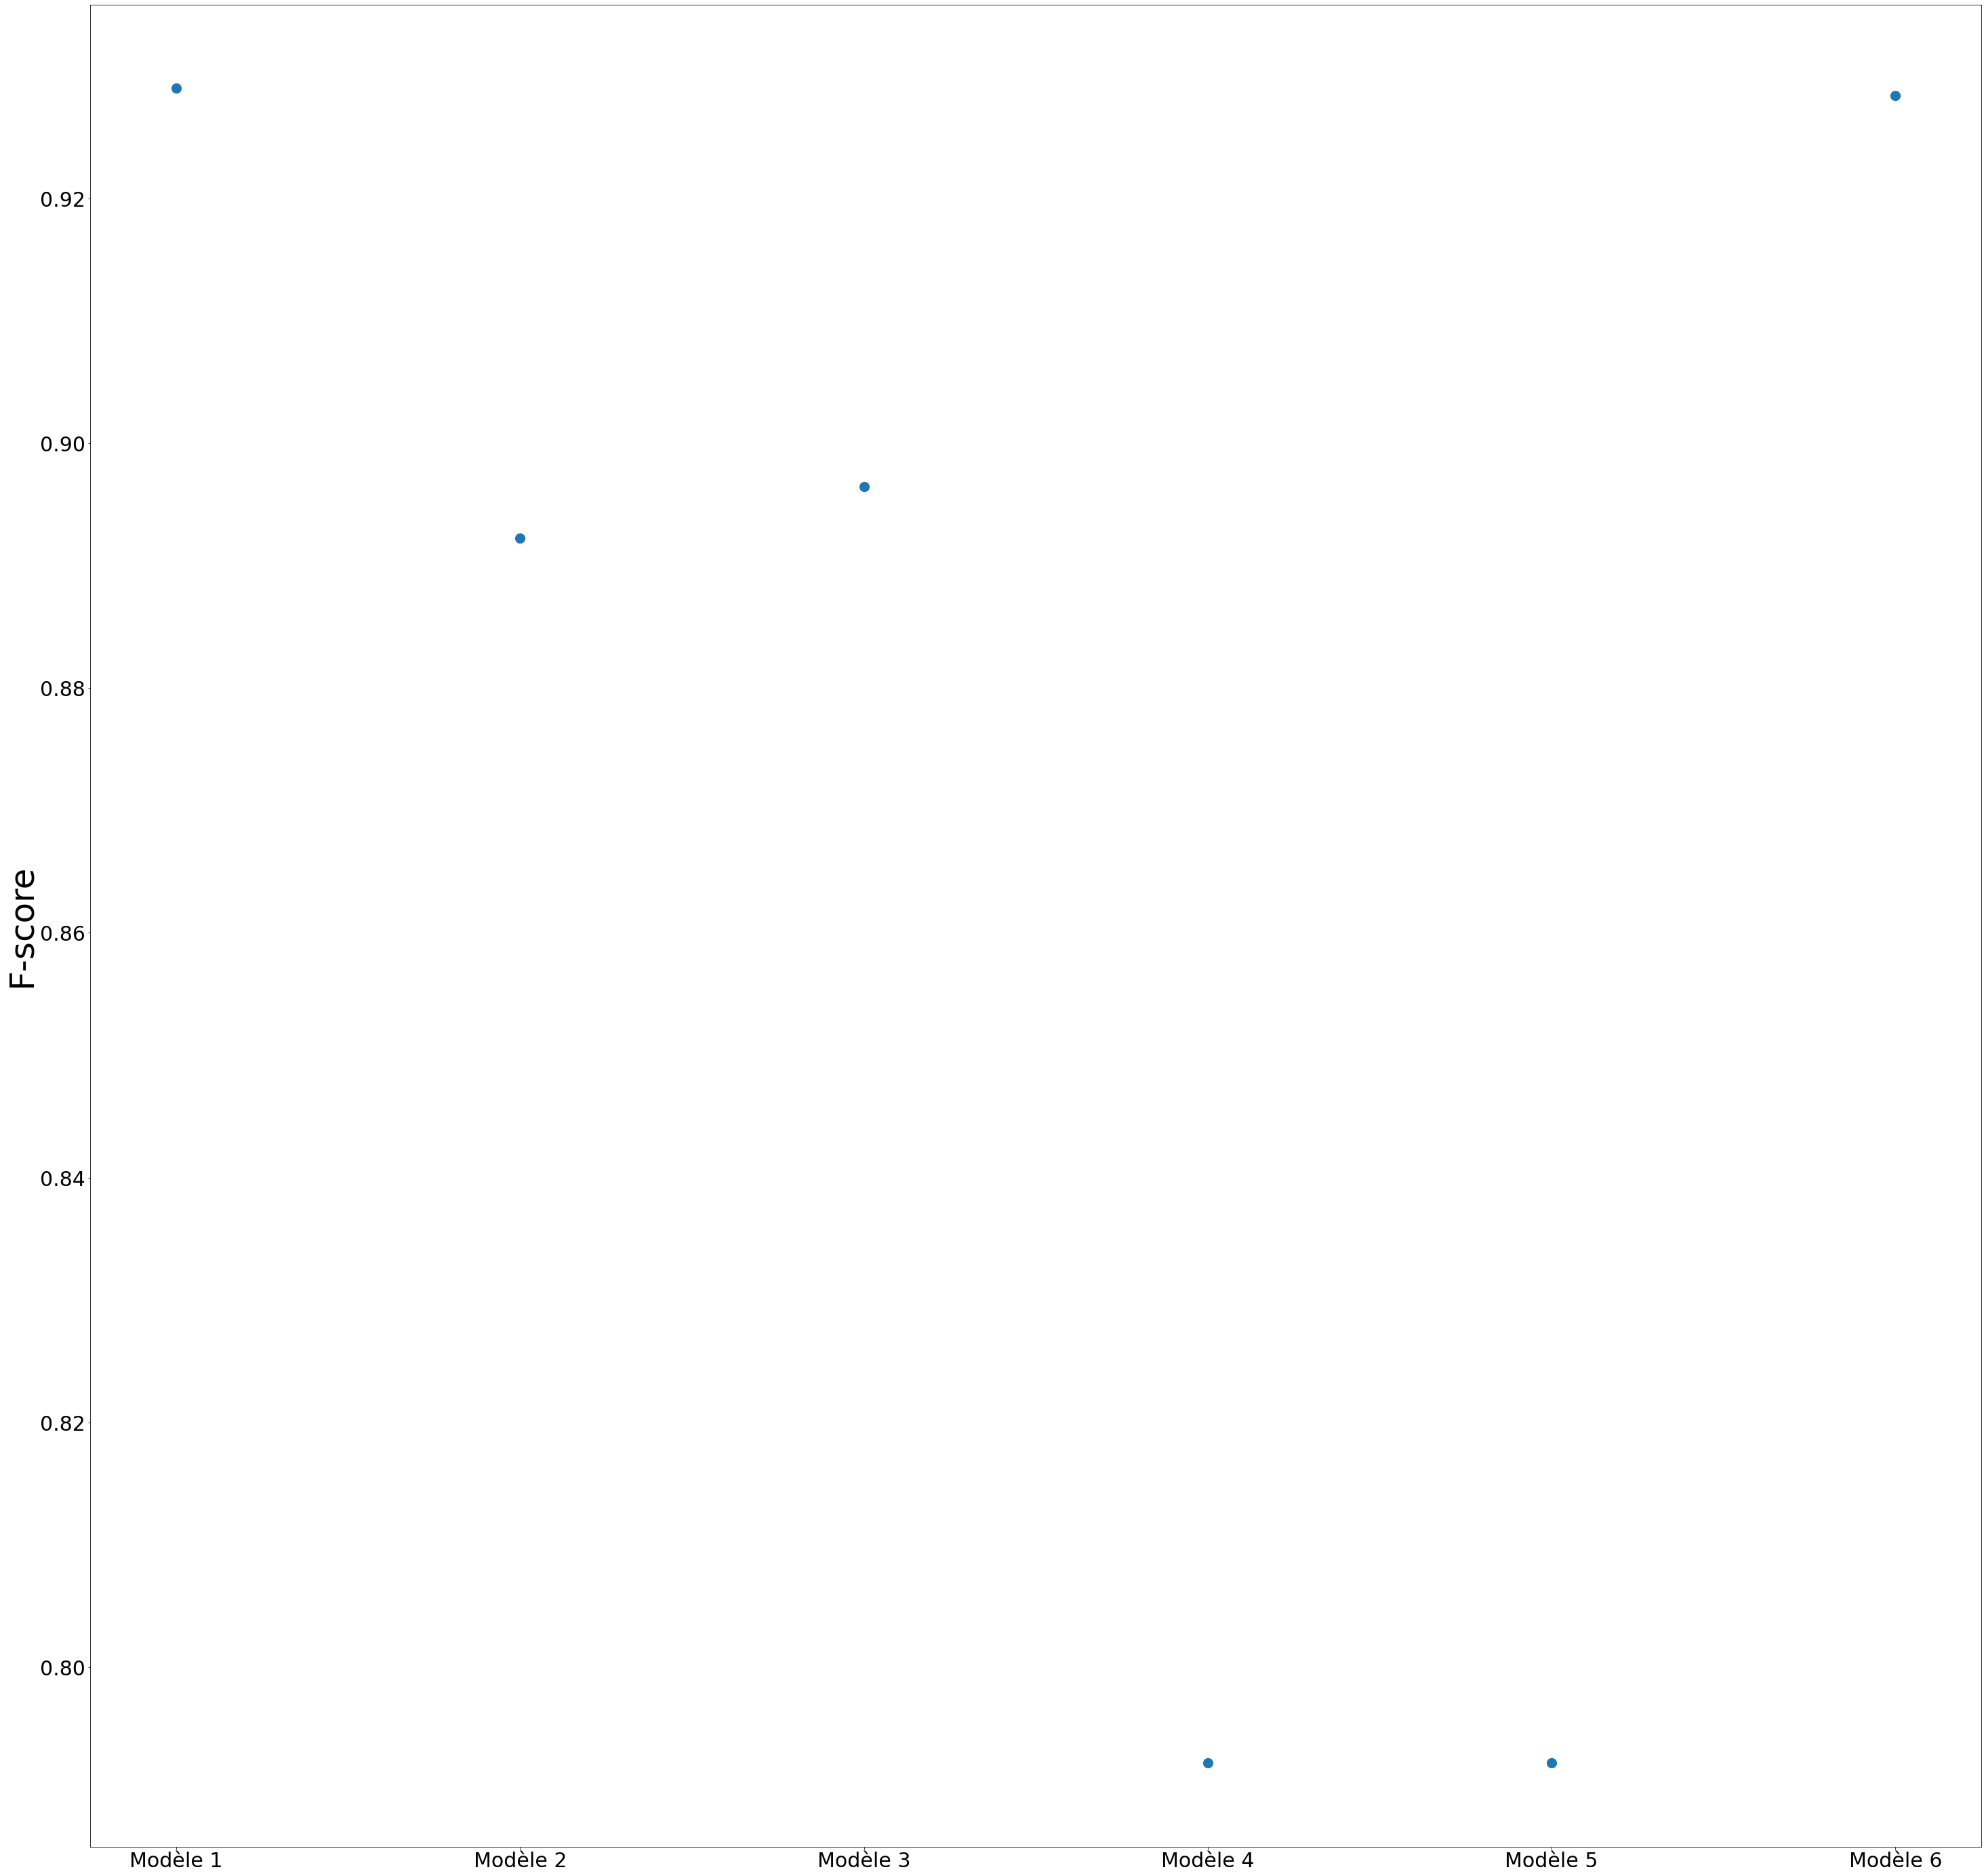

In [59]:
fscores = [fscore1, fscore2, fscore4, fscore5, fscore7, fscore9]
# models = ["5 plus proches voisins sans entrainement", "5 plus proches voisins avec entrainement", "3 plus proches voisins avec entrainement", "Régression logistique non régularisée", "Régression logistique régularisation ridge", "Forêt aléatoire"]
models = ["Modèle 1", "Modèle 2", "Modèle 3", "Modèle 4", "Modèle 5", "Modèle 6"]

plt.scatter(models, fscores, s=200)
plt.ylabel("F-score", fontsize=50)
plt.show()

#### Question 15.b
Utilisez cette figure pour __sélectionner votre modèle favori__. Quel pré-traitement choisissez-vous ? Quel algorithme choisissez-vous, avec quel hyper-paramètre ? 

__Réponse :__

Les modèles 1 et 6, respectivement des 5 plus proches voisins sans entraînement et de la forêt aléatoire, affichent les plus belles performances, avec un f-score de $0.93$.

On choisit donc en modèle favori celui de la forêt aléatoire avec le nombre d'arbres obtenu par validation croisée et entraîné sur les données `(X_train, y_train)`. Ces dernières sont des données qui ont subi un pré-traitement : elles sont centrées réduites.

#### Question 16.a
Chargez les données privées de `data/foret_prive.tsv` pour obtenir un array `X_private`. Le fichier suit la même syntaxe que `data/foret_public.tsv`, mais sans la colonne des étiquettes.

In [60]:
df_private = pd.read_csv('data/foret_prive.tsv', delimiter='\t')

X_private = np.array(df_private)

#### Question 16.b
Appliquez le pré-traitement que vous avez choisi à l'intégralité du jeu de données public `X_public` pour obtenir `X_public_preprocessed`.

In [61]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_public)

X_public_preprocessed = standard_scaler.transform(X_public)

#### Question 16.c
Appliquez à `X_private` le pré-traitement que vous avez choisi ; enregistrez le résultat dans `X_private_preprocessed`.

In [62]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_private)

X_private_preprocessed = standard_scaler.transform(X_private)

#### Question 16.d
Entraînez l'algorithme que vous avez sélectionné sur l'intégralité des données publiques `(X_public_processed, y_public)`. 

In [63]:
# initialisation d'un objet RandomForestClassifier
predictor = RandomForestClassifier(n_estimators = best_n)

# entraînement de cet objet sur les données.
predictor.fit(X_public_preprocessed, y_public)

RandomForestClassifier(n_estimators=176)

#### Question 16.e
Prédisez les étiquettes de `X_private_preprocessed` ; enregistrez le résultat dans un array `y_pred_final`

In [64]:
y_pred_final = predictor.predict(X_private_preprocessed)

#### Question 16.f
Utilisez le code suivant pour créer le fichier de prédictions que vous rendrez. 

__Attention__ Si vous ouvrez ce fichier avec un programme externe type Microsoft Excel ou LibreOffice Calc pour le lire, il est possible que ce programme modifie le fichier sans que vous ne le réalisiez. Préférez utiliser une commande bash type `less` ou `cat` ou éditeur de texte simple ; ou alors assurez-vous de relancer la commande.

In [65]:
# Save array to file
np.savetxt("test_file.tsv", 
           y_pred_final,
           fmt=('%d'), 
           header='Prediction',
           delimiter='\t', comments="")

## Bonus

1. En alternative au F-score, utilisez des courbes ROC (et l'aire sous ces courbes) pour comparer vos modèles. Attention à utiliser les méthodes `predict_proba()` plutôt que `predict()` pour obtenir des scores non-seuillés plutôt que des prédictions binaires. Documentation pertinente : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html et  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html.

1. Explorez d'autres pré-traitements (comme par exemple le fait de réduire la dimension des données) et d'autres algorithmes d'apprentissage implémentés dans scikit-learn (par exemple SVM, perceptrons multi-couches) pour essayer d'améliorer vos prédictions et reprenez la question 15.